# Stage 1 数据预处理

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
#from sklearn.cross_validation import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer
from sklearn.model_selection import cross_val_score,GridSearchCV
import math
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import linear_model
from sklearn.linear_model import Lasso,ElasticNet,Ridge,BayesianRidge,RANSACRegressor,HuberRegressor,LassoCV
from sklearn import ensemble
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,ExtraTreesClassifier,AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import  make_scorer,mean_squared_error,r2_score
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.feature_selection import SelectKBest

In [27]:
%matplotlib inline
SKIPMAP = False

In [39]:
path_train=r"C:\Users\corem\Documents\Python Scripts\titanic\train.csv"
path_test=r"C:\Users\corem\Documents\Python Scripts\titanic\test.csv"

In [40]:
train=pd.read_csv(path_train)
raw_test=pd.read_csv(path_test)
test=pd.read_csv(path_test)

In [41]:
full_data=pd.concat([train,test],axis=0,ignore_index=True)
ntrain=train.shape[0]
x_train=train.drop(['Survived','PassengerId'],axis=1)
y_train=train.Survived

D:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [42]:
# 特征预处理map函数
def change_age(x):
    if x < 16:
        return 1
    else:
        return 0


def change_family(x):
    if x == 1 or x == 2 or x == 3:
        return 1
    else:
        return 0


def change_embarked(x):
    if x == 'S':
        return 0
    elif x == 'C':
        return 1
    elif x == 'Q':
        return 2


def pro_train_data(datas):
    datas['family'] = datas.SibSp + datas.Parch
    datas.loc[[65, 159, 176, 709], 'Age'] = 15
    age = datas.Age.map(change_age)
    datas['Age'] = age
    datas['family'] = datas.family.map(change_family)
    cabin_datas = datas.Cabin.replace(np.nan, 0)
    datas['Cabin'] = np.where(cabin_datas == 0, 0, 1)
    datas.Embarked.fillna('C', inplace=True)
    datas['Embarked'] = datas.Embarked.map(change_embarked)
    datas['Sex'] = np.where(datas['Sex'] == 'female', 1, 0)
    to_drop = ['PassengerId', 'Name', 'Ticket', 'SibSp',
               'Parch']
    datas_handle = datas.drop(to_drop, axis=1)
    return datas_handle


def pro_test_data(test_datas):
    test_datas.loc[(test_datas.Fare.isnull()), 'Fare'] = test_datas[
        (test_datas.Embarked == 'S') & (test_datas.Pclass == 3)].Fare.median()
    test_datas['family'] = test_datas.SibSp + test_datas.Parch
    test_datas.loc[[244, 344, 417], 'Age'] = 15
    age = test_datas.Age.map(change_age)
    test_datas['Age'] = age
    test_datas['family'] = test_datas.family.map(change_family)
    cabin_datas = test_datas.Cabin.replace(np.nan, 0)
    test_datas['Cabin'] = np.where(cabin_datas == 0, 0, 1)
    test_datas.Embarked.fillna('S', inplace=True)
    test_datas['Embarked'] = test_datas.Embarked.map(change_embarked)
    test_datas['Sex'] = np.where(test_datas['Sex'] == 'female', 1, 0)
    to_drop = ['PassengerId', 'Name', 'Ticket', 'SibSp',
               'Parch']
    new_test_data_handle = test_datas.drop(to_drop, axis=1)

    return new_test_data_handle

In [43]:
train_pro = pro_train_data(train)
test_pro = pro_test_data(test)

### 1.1 EDA

In [124]:
def eda_plot(df,cols=[],target=y_train):

    ax_nth =len(cols)
    fig,ax =plt.subplots(2,ax_nth,figsize=(ax_nth*4,5))
    for i in range(ax_nth):
        col=cols[i]
        data = df[col]
        
        if  (len(data.unique())<10):
            sns.countplot(data[data.notnull()], ax=ax[0,i])
            sns.barplot(data,target,ax=ax[1,i])
        elif (data.dtype == np.float64) and (len(data.unique())>10):
            sns.distplot(data[data.notnull()], ax=ax[0,i])
            sns.regplot(data,target,ax=ax[1,i])
                    #ax[1,i].set_title(col) 


        plt.subplots_adjust(hspace=0.1,wspace=0.1)
        

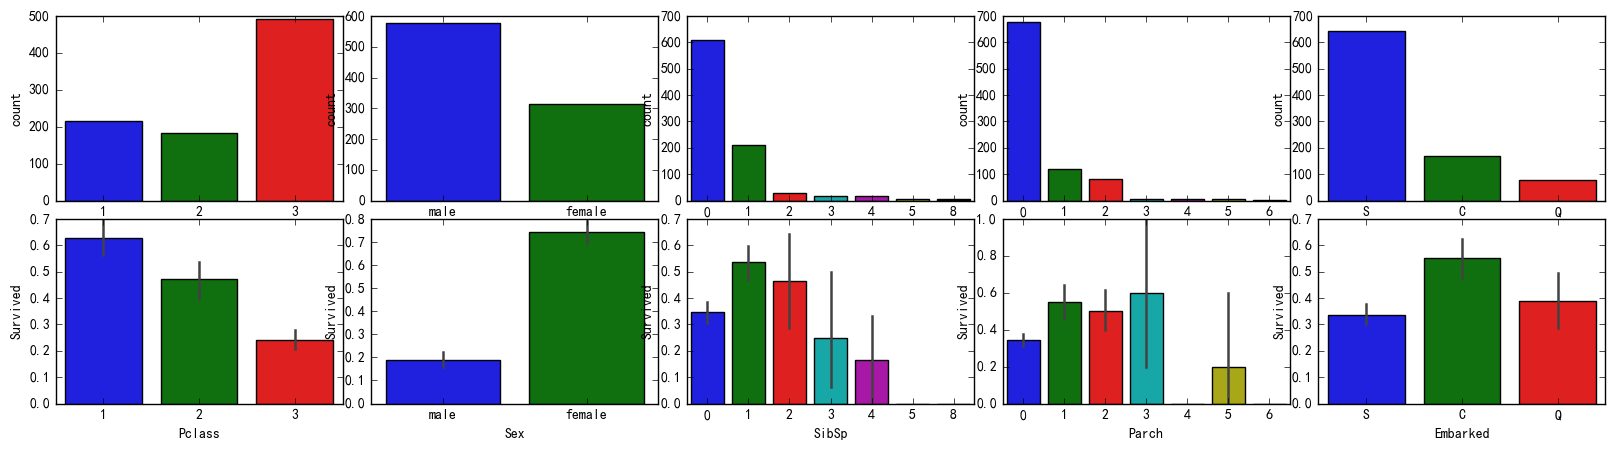

In [125]:
cols_short = ['Pclass','Sex','SibSp','Parch','Embarked']
eda_plot(df=x_train,cols=cols_short,target=y_train)

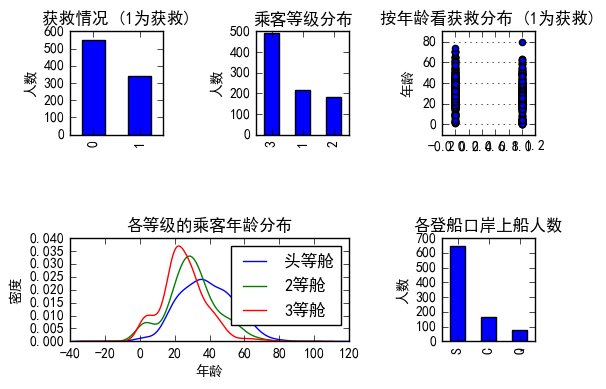

In [107]:
plt.rcParams['font.sans-serif']=['SimHei']#用来显示正常中文标签
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

plt.subplot2grid((2,3),(0,0))             # 在一张大图里分列几个小图
train.Survived.value_counts().plot(kind='bar')# 柱状图 
plt.title(u"获救情况 (1为获救)") # 标题
plt.ylabel(u"人数")  

plt.subplot2grid((2,3),(0,1))
train.Pclass.value_counts().plot(kind="bar")
plt.ylabel(u"人数")
plt.title(u"乘客等级分布")

plt.subplot2grid((2,3),(0,2))
plt.scatter(train.Survived, train.Age)
plt.ylabel(u"年龄")                         # 设定纵坐标名称
plt.grid(b=True, which='major', axis='y') 
plt.title(u"按年龄看获救分布 (1为获救)")


plt.subplot2grid((2,3),(1,0),colspan=2)
train.Age[train.Pclass == 1].plot(kind='kde')   
train.Age[train.Pclass == 2].plot(kind='kde')
train.Age[train.Pclass == 3].plot(kind='kde')
plt.xlabel(u"年龄")# plots an axis lable
plt.ylabel(u"密度") 
plt.title(u"各等级的乘客年龄分布")
plt.legend((u'头等舱', u'2等舱',u'3等舱'),loc='best') # sets our legend for our graph.


plt.subplot2grid((2,3),(1,2))
train.Embarked.value_counts().plot(kind='bar')
plt.title(u"各登船口岸上船人数")
plt.ylabel(u"人数")  

plt.subplots_adjust(wspace =1, hspace =1)
plt.show()

1.Embarked

Embarked有两个缺失值，Pclass都是1，Fare都是80，Ticket都是113572，有理由认为两者的Embarked也应该是一样的。

综合考虑Pclass和Fare，将缺失值填充为C

In [67]:
train['Embarked'].fillna('C',inplace=True)

In [68]:
# Mapping Embarked
#因为C口的生还率最高，所以映射为0
train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
test['Embarked'] = test['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

2.Fare

测试集有一个确实值

使用Pclass为3和Embarked为S的fare中位数填充缺失值

In [69]:
full_data[(full_data['Pclass']==3) & (full_data['Embarked']=='S')]['Fare'].median()

8.05

In [70]:
test['Fare'].fillna(8,inplace=True)

In [71]:
#Mapping Fare 
train['CategoricalFare'] = pd.qcut(train['Fare'], 4,labels=False)
test['CategoricalFare'] = pd.qcut(train['Fare'], 4,labels=False)
print (train[['CategoricalFare', 'Survived']].groupby(['CategoricalFare'], as_index=False).mean())

   CategoricalFare  Survived
0                0  0.197309
1                1  0.303571
2                2  0.454955
3                3  0.581081


3.Age

In [72]:
full_data[full_data.Age.isnull()].head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
5,NaN,NaN,Q,8.4583,"Moran, Mr. James",0,6,3,male,0,0.0,330877
17,NaN,NaN,S,13.0000,"Williams, Mr. Charles Eugene",0,18,2,male,0,1.0,244373
19,NaN,NaN,C,7.2250,"Masselmani, Mrs. Fatima",0,20,3,female,0,1.0,2649
26,NaN,NaN,C,7.2250,"Emir, Mr. Farred Chehab",0,27,3,male,0,0.0,2631
28,NaN,NaN,Q,7.8792,"O'Dwyer, Miss. Ellen ""Nellie""",0,29,3,female,0,1.0,330959


In [73]:
train.loc[[65, 159, 176, 709], 'Age'] = 15
test.loc[[244, 344, 417], 'Age'] = 15

In [74]:
# Mapping Age
def mapping_age(x):
    if x<16:
        return 1
    else:
        return 0
#    dataset.loc[ dataset['Age'] < 16, 'CategoricalAge']= 1
#    dataset.loc[ dataset['Age'] >= 16, 'CategoricalAge']= 0
#    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'CategoricalAge'] = 1
#    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'CategoricalAge'] = 2
#    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'CategoricalAge'] = 3
#    dataset.loc[ dataset['Age'] > 64, 'CategoricalAge']                           = 4
#    return dataset

In [75]:
#fill null
train['CategoricalAge']=train['Age']
test['CategoricalAge']=test['Age']
train['CategoricalAge'].fillna(full_data['Age'].median(),inplace=True)
test['CategoricalAge'].fillna(full_data['Age'].median(),inplace=True)

In [76]:
train['CategoricalAge']=train['CategoricalAge'].astype('int')
test['CategoricalAge']=test['CategoricalAge'].astype('int')

In [77]:
train['CategoricalAge'] = pd.cut(train['CategoricalAge'], 5,labels=False)
print (train[['CategoricalAge', 'Survived']].groupby(['CategoricalAge'], as_index=False).mean())

   CategoricalAge  Survived
0               0  0.548077
1               1  0.343570
2               2  0.403226
3               3  0.434783
4               4  0.090909


In [78]:
train['CategoricalAge']=train.CategoricalAge.map(mapping_age)
test['CategoricalAge']=test.CategoricalAge.map(mapping_age)

4.Name

In [119]:
def get_title(name):
    title_search = re.search('([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    else:
        return np.nan

In [120]:
train['Title'] = train['Name'].apply(get_title)
test['Title'] = test['Name'].apply(get_title)

In [121]:
pd.crosstab(test['Title'], test['Sex'])

Sex,female,male
Title,,
Col,0,2
Dona,1,0
Dr,0,1
Master,0,21
Miss,78,0
Mr,0,240
Mrs,72,0
Ms,1,0
Rev,0,2


In [122]:
def fill_name(dataset):
    dataset['Title'] = dataset['Title'].replace(['Capt' ,'Don','Dr', 'Rev', 'Jonkheer'], 'Other')
    dataset['Title'] = dataset['Title'].replace(['Sir','Col','Major'],'Major')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace('Dona','Mrs')
    dataset['Title'] = dataset['Title'].replace(['Countess','Lady'],'Mrs')
    return dataset
train=fill_name(train)
test=fill_name(test)
print (train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean())

    Title  Survived
0   Major  0.600000
1  Master  0.575000
2    Miss  0.702703
3      Mr  0.156673
4     Mrs  0.796875
5   Other  0.187500


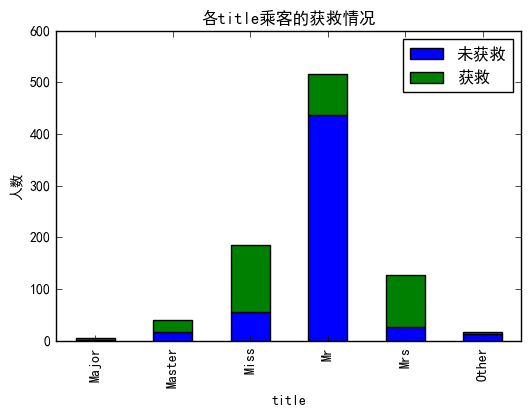

In [123]:
#从乘客姓名中获取头衔


fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_m = train.Title[train.Survived == 0].value_counts()
Survived_f = train.Title[train.Survived == 1].value_counts()
df=pd.DataFrame({u'获救':Survived_f, u'未获救':Survived_m})
df.plot(kind='bar', stacked=True)
plt.title(u"各title乘客的获救情况")
plt.xlabel(u"title") 
plt.ylabel(u"人数") 
plt.show()

In [85]:
# Mapping titles
title_mapping = {"Other":0,"Mr": 1,  "Master": 2, "Major": 2, "Miss": 3,"Mrs":4}
train['Title'] = train['Title'].map(title_mapping)
test['Title'] = test['Title'].map(title_mapping)

 5.SibSp and Parch

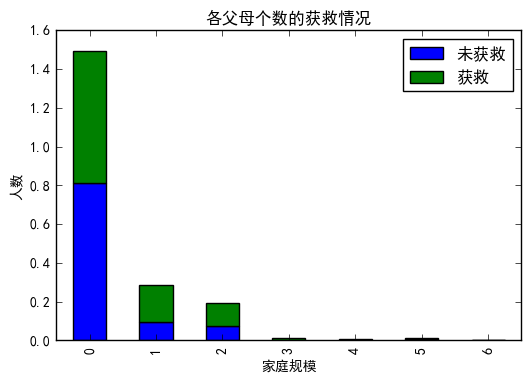

In [113]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_m = train.Parch[train.Survived == 0].value_counts(normalize=True)
Survived_f = train.Parch[train.Survived == 1].value_counts(normalize=True)
df=pd.DataFrame({u'获救':Survived_f, u'未获救':Survived_m})
df.plot(kind='bar', stacked=True)
plt.title(u"各父母个数的获救情况")
plt.xlabel(u"家庭规模") 
plt.ylabel(u"人数") 
plt.show()

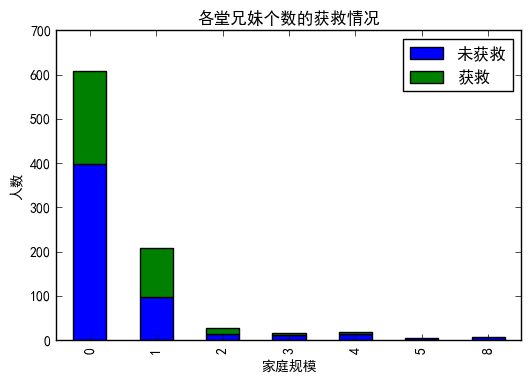

In [114]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_m = train.SibSp[train.Survived == 0].value_counts()
Survived_f = train.SibSp[train.Survived == 1].value_counts()

df=pd.DataFrame({u'获救':Survived_f, u'未获救':Survived_m})
df.plot(kind='bar', stacked=True)
plt.title(u"各堂兄妹个数的获救情况")
plt.xlabel(u"家庭规模") 
plt.ylabel(u"人数") 
plt.show()

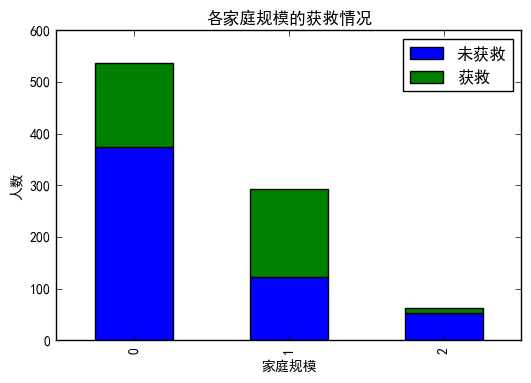

In [112]:
train['familyNum']=train['Parch']+train['SibSp']+1
test['familyNum']=test['Parch']+test['SibSp']+1
#按照家庭成员人数多少，将家庭规模分为“小、中、大”三类：
def familysize(familyNum):
    if familyNum==1:
        return 0
    elif (familyNum>=2)&(familyNum<=4):
        return 1
    else:
        return 2
train['familySize']=train['familyNum'].map(familysize)
test['familySize']=test['familyNum'].map(familysize)

Survived_m = train.familySize[train.Survived == 0].value_counts()
Survived_f = train.familySize[train.Survived == 1].value_counts()

df=pd.DataFrame({u'获救':Survived_f, u'未获救':Survived_m})
df.plot(kind='bar', stacked=True)
plt.title(u"各家庭规模的获救情况")
plt.xlabel(u"家庭规模") 
plt.ylabel(u"人数") 
plt.show()

In [86]:
def mapping_family(dataset):
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    dataset.loc[(dataset['FamilySize']>1) & (dataset['FamilySize']<5),'FamilySize']=2
    dataset.loc[(((dataset['FamilySize']>=5)&(dataset['FamilySize']<=7)) | (dataset['FamilySize']==1)),'FamilySize']=1
    dataset.loc[(dataset['FamilySize']>7),'FamilySize']=0
    return dataset
train=mapping_family(train)
test=mapping_family(test)
print (train[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean())

   FamilySize  Survived
0           0  0.000000
1           1  0.295222
2           2  0.578767


In [87]:
def mapping_isalone(dataset):
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    return dataset
train=mapping_isalone(train)
test=mapping_isalone(test)
print (train[['IsAlone', 'Survived']].groupby(['IsAlone'], as_index=False).mean())

   IsAlone  Survived
0        0  0.554098
1        1  0.295222


6.Cabin

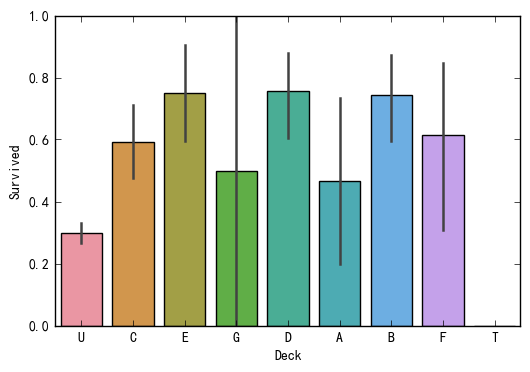

In [88]:
#先填补空缺值
train['Cabin']=train['Cabin'].fillna('Unknow')
test['Cabin']=test['Cabin'].fillna('Unknow')
train['Deck']=train['Cabin'].str.get(0)
test['Deck']=test['Cabin'].str.get(0)
sns.barplot(x='Deck',y="Survived",data=train)

In [89]:
# Mapping Deck
deck_mapping = {"T":0,  "U":1,"G": 1,  "A": 1, "C": 2, "E": 2,"D":2,"B":2,"F":2}
def deck_mapping2(x):
    if x=='U':
        return 0
    else:
        return 1
train['Deck'] = train['Deck'].map(deck_mapping2)
test['Deck'] = test['Deck'].map(deck_mapping2)

7.Ticket

In [90]:
Ticket_Count = dict(full_data['Ticket'].value_counts())

In [91]:
train['TicketGroup'] = train['Ticket'].apply(lambda x:Ticket_Count[x])
test['TicketGroup'] = test['Ticket'].apply(lambda x:Ticket_Count[x])

<function seaborn.categorical.barplot>

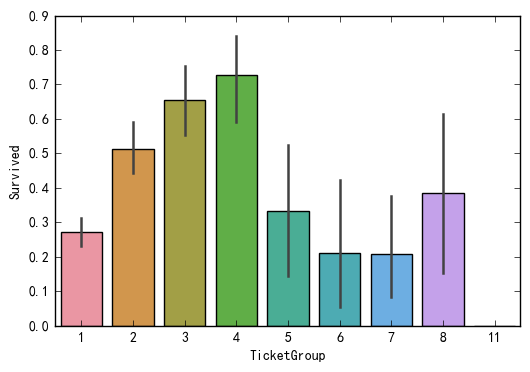

In [92]:
Ticket_Count = dict(full_data['Ticket'].value_counts())
train['TicketGroup'] = train['Ticket'].apply(lambda x:Ticket_Count[x])
test['TicketGroup'] = test['Ticket'].apply(lambda x:Ticket_Count[x])
sns.barplot(x='TicketGroup',y="Survived",data=train)
sns.barplot

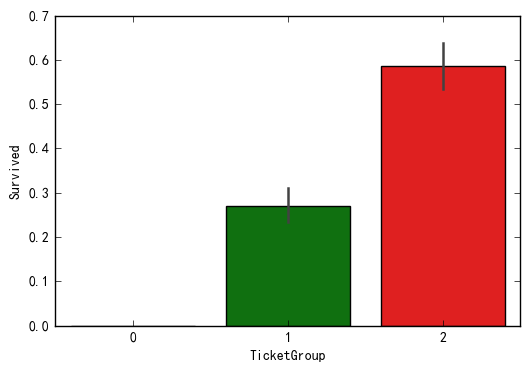

In [93]:
def Ticket_Label(s):
    if (s>= 2) & (s<=4):
        return 2;
    elif ((s>=5) & (s<=8) | (s==1)):
        return 1;
    else:
        return 0;

train['TicketGroup']=train['TicketGroup'].apply(Ticket_Label)
test['TicketGroup']=test['TicketGroup'].apply(Ticket_Label)
sns.barplot(x='TicketGroup',y="Survived",data=train)

8.sex

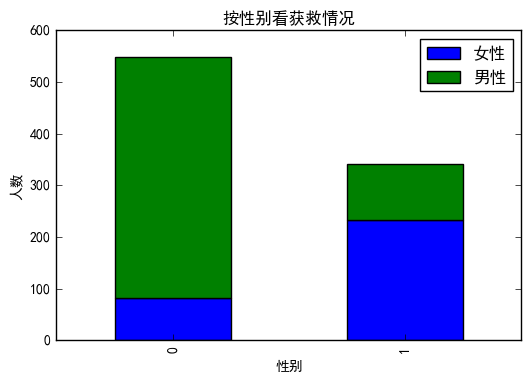

In [117]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_m = train.Survived[train.Sex == 'male'].value_counts()
Survived_f = train.Survived[train.Sex == 'female'].value_counts()
df=pd.DataFrame({u'男性':Survived_m, u'女性':Survived_f})
df.plot(kind='bar', stacked=True)
plt.title(u"按性别看获救情况")
plt.xlabel(u"性别") 
plt.ylabel(u"人数")
plt.show()

In [94]:
train['Sex'] = train['Sex'].map( {'female': 1, 'male': 0} ).astype(int)
test['Sex'] = test['Sex'].map( {'female': 1, 'male': 0} ).astype(int)

  9.Pclass

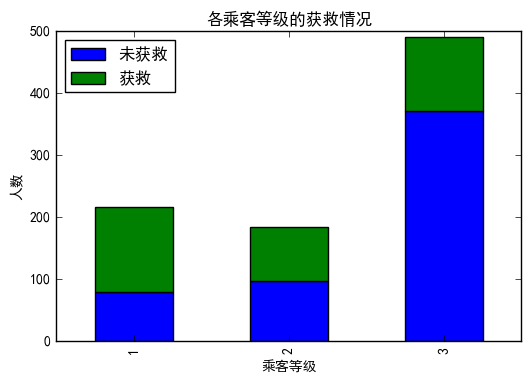

In [116]:
fig = plt.figure()
fig.set(alpha=0.2)  # 设定图表颜色alpha参数

Survived_m = train.Pclass[train.Survived == 0].value_counts()
Survived_f = train.Pclass[train.Survived == 1].value_counts()
df=pd.DataFrame({u'获救':Survived_f, u'未获救':Survived_m})
df.plot(kind='bar', stacked=True)
plt.title(u"各乘客等级的获救情况")
plt.xlabel(u"乘客等级") 
plt.ylabel(u"人数") 
plt.show()

# Stage2 Training & Prediction

In [134]:
xgb = XGBClassifier(n_estimators=50,learning_rate=0.05,
                      subsample=0.5,
                      #colsample_bytree=0.4603, gamma=0.0468, 
                      #max_depth=3, min_child_weight=1.7817, 
                      #reg_alpha=0.4640, reg_lambda=0.8571,
                      # silent=1,
                      seed=2019)

lgbm =lgb.LGBMClassifier(n_estimators=50,learning_rate=0.05,
                      subsample=0.5,
                      #colsample_bytree=0.4603, gamma=0.0468, 
                      #max_depth=3, min_child_weight=1.7817, 
                      #reg_alpha=0.4640, reg_lambda=0.8571,
                      # silent=1,
                      seed=2019)

gbr = GradientBoostingClassifier(n_estimators=50,
                                learning_rate=0.05, subsample=0.5,
                               # max_features='sqrt',min_samples_leaf=15,
                               # min_samples_split=10,max_depth=4,
                                random_state=2019) # difficult to use for hyper tuning

rf = RandomForestClassifier(n_estimators=50) 

lr = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial',class_weight=class_weight)
#dtree = DecisionTreeClassifier()

In [135]:
Params_LGBMClassifier={
                     #"Scaler":[RobustScaler(),StandardScaler()],
                      'n_estimators':[50,100,200],
                       "learning_rate":np.logspace(-2,-1,2), #学习速率
                       "max_depth":[3,5,7]
                              }

Params_XGBClassifier={
                            #"Scaler":[StandardScaler(),RobustScaler()],
                              'n_estimators':[50,100,200],
                               "learning_rate":[0.01,0.05,0.1],
                               "max_depth":[3,5,7]
                       #        "reg_alpha":np.logspace(-3,-1,3),
                       #        "reg_lambda":np.logspace(-2,0,3)
                              }

Params_GradientBoostingClassifier={
                             #"Scaler":[RobustScaler(),StandardScaler()],
                                   'n_estimators':[50,100,200],#学习器个数
                               "learning_rate":[0.01,0.05,0.1], #学习速率
                                "max_depth":[3,4,5]
                              }
Params_RandomForestClassifier={
                                 #"Scaler":[RobustScaler(),StandardScaler()],
                                   'classify__n_estimators':[36],#学习器个数
                                'classify__max_depth':[6]

                              }
Params_DecisionTreeClassifier={
    'criterion':['gini', 'entropy'],
    'max_depth': [3,4,5,6]   
}
Params_groups ={"LGBMClassifier":Params_LGBMClassifier,
                "XGBClassifier":Params_XGBClassifier,
                "GradientBoostingClassifier":Params_GradientBoostingClassifier,
                "RandomForestClassifier":Params_RandomForestClassifier,
                "DecisionTreeClassifier":Params_DecisionTreeClassifier
               }

In [136]:
def make_clf_grids(estimators_list):
    #clf_grids 
    #Key : 模型的名字
    #Value is a list [ x0,x1,x2,x3]
    #value[0] 模型
    #values[1] 待调整的参数
    #values[2] 训练后的模型
    #values[3] 梯度搜索后的最佳分数
    #values[4] 在测试集上的预测值
    
    grids={}
    for x in estimators_list:
        name = (type(x).__name__)
        grids[name]=[x,{},None,None,None]    
        grids[name][1] = Params_groups[name]
    return grids
#full_estimators_list =[rf]
full_estimators_list =[lgbm,xgb,gbr,dtree] 
clf_grids = make_clf_grids(full_estimators_list)

In [137]:
def baseline_cols(train,nCV=4):
    x_train=train.drop(['Survived'],axis=1)
    y_train=train.Survived   
    all_means =[]
    for i in full_estimators_list:
        estimator = i
        name = type(estimator).__name__
        #print(name)
        pipe = Pipeline([
                         #("Scaler",RobustScaler()),
                         #("selector",SelectFromModel(LassoCV(cv=5),threshold=1e-5)),
                         ("clf",estimator)])
        
        cv_scores = cross_val_score(pipe,x_train,y_train,cv=nCV)  
        mean_score =cv_scores.mean()
        print("{0:.4f} \t\t{1}".format(mean_score,name))
        all_means.append(cv_scores)      
                                       
    return all_means        

In [154]:
def Tuning_clf(name,train,search_type="Grid",nCV=3):
    x_train=train.drop(['Survived'],axis=1)
    y_train=train.Survived  
    estimator = clf_grids[name][0]
    estimator_params=clf_grids[name][1]
    
#    pipe=Pipeline([('select',SelectKBest(k=20)), 
    #           ('clf', estimator)])
    
    starttime = datetime.datetime.now()
    
    def params_size(estimator_params):
        size = 0
        nlen=0
        
        for k,v in estimator_params.items():
            size +=len(v)
        return size
        
    if search_type =="Grid" or params_size(estimator_params)<=10:
        rsearch = GridSearchCV(estimator, param_grid=estimator_params,scoring ='accuracy',cv=nCV,refit =True)
    else:
        rsearch = RandomizedSearchCV(estimator, param_distributions=estimator_params,
                                     scoring ='accuracy',cv=nCV,refit =True)
    
    grid_result=rsearch.fit(x_train,y_train)
    endtime = datetime.datetime.now()
    print("running time:{0} seconds".format((endtime - starttime).seconds))
    print("Best score: %.4f using %s" % (grid_result.best_score_,grid_result.best_params_))
    
    means = grid_result.cv_results_['mean_test_score']
    #params = grid_result.cv_results_['params']    
#    for mean,param in zip(means,params):
#        print("%.4f  with:   %r" % (mean,param))
      
    return grid_result

In [155]:
path_train=r"C:\Users\corem\Documents\Python Scripts\titanic\train_feature.csv"
path_test=r"C:\Users\corem\Documents\Python Scripts\titanic\test_feature.csv"
path_test_raw=r"C:\Users\corem\Documents\Python Scripts\titanic\test.csv"
train_pro=pd.read_csv(path_train)
test_pro=pd.read_csv(path_test)
raw_test=pd.read_csv(path_test_raw)

In [156]:
cols=[x for x in train_pro.columns]
cols.remove('Unnamed: 0')

In [157]:
#cols是训练模型的特征
#cols=['Pclass','Sex','Embarked','Cabin','Fare','Age','family' , 'Survived']
cols_test = cols.copy()
cols_test.remove('Survived')
train_pro=train_pro[cols]
test_pro= test_pro[cols_test]

In [158]:
def trainvstest(train,test):
    from scipy.stats import ks_2samp
    tab_combined=pd.concat([train,test],axis=0,keys=["train","test"],names=["sets"])
    tmp_data = tab_combined.head().reset_index(level=0)
    num_cols = tmp_data.select_dtypes(include=["number"]).columns
    num_cols = num_cols.drop(['Survived'])
    total_num_cols = len(num_cols[:5])
    #print(num_cols)
    for col in num_cols:
        v_ks,p_ks=ks_2samp(train[col],test[col])
        if p_ks<0.2:
            print("KS: {0:,.2f}\t Pvalue {1:.2f}\t {2}".format(v_ks,p_ks,col))


### 2.0 训练集和测试集分布是否一致

In [159]:
trainvstest(train_pro,test_pro)

KS: 0.08	 Pvalue 0.07	 Embarked_S


D:\Program Files\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


### 2.1 base line

In [160]:

#base line
all_meas=baseline_cols(train_pro[cols],nCV=3)

0.8227 		LGBMClassifier
0.8182 		XGBClassifier
0.8249 		GradientBoostingClassifier
0.7767 		DecisionTreeClassifier


### 2.2 调参

In [161]:
estimators_names = [x for x in clf_grids.keys()]
test=test_pro[cols_test]   
compare = pd.DataFrame(columns=['Model','Mean score'])
for i in  range(len(estimators_names)):
    name=estimators_names[i]
    print(name)
    print(clf_grids[name][1])
    tuned_clf=Tuning_clf(name,train_pro[cols],nCV=3)
    best_estimator = tuned_clf.best_estimator_

    best_score = -tuned_clf.best_score_ 
    mean_score = tuned_clf.cv_results_['mean_test_score'].mean()
    Pred_Y=best_estimator.predict(test)
    clf_grids[name][2]=best_estimator
    clf_grids[name][3]=best_score
    clf_grids[name][4]=Pred_Y
    print("\n")
    compare.loc[i,'Model'] = name
    compare.loc[i,'Mean score'] = mean_score

GradientBoostingClassifier
{'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 4, 5]}
running time:15 seconds
Best score: 0.8350 using {'n_estimators': 200, 'learning_rate': 0.01, 'max_depth': 5}


XGBClassifier
{'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.05, 0.1], 'max_depth': [3, 5, 7]}
running time:15 seconds
Best score: 0.8361 using {'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 3}


DecisionTreeClassifier
{'criterion': ['gini', 'entropy'], 'max_depth': [3, 4, 5, 6]}
running time:0 seconds
Best score: 0.8227 using {'criterion': 'gini', 'max_depth': 4}


LGBMClassifier
{'n_estimators': [50, 100, 200], 'learning_rate': array([0.01, 0.1 ]), 'max_depth': [3, 5, 7]}
running time:3 seconds
Best score: 0.8384 using {'n_estimators': 50, 'learning_rate': 0.1, 'max_depth': 5}




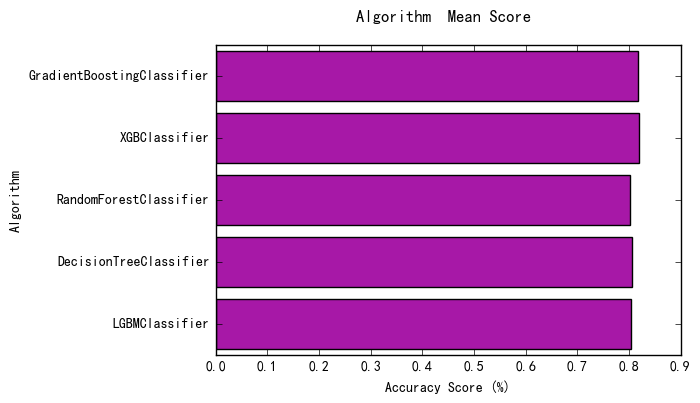

In [48]:
sns.barplot(x='Mean score', y = 'Model', data = compare, color = 'm')

#prettify using pyplot: https://matplotlib.org/api/pyplot_api.html
plt.title('Algorithm  Mean Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

### 2.3 模型的特征重要性

In [49]:
feature_dataframe=pd.DataFrame({"features":cols_test,"XGBClassifier":clf_grids['XGBClassifier'][2].feature_importances_,
                                "GradientBoostingClassifier":clf_grids['GradientBoostingClassifier'][2].feature_importances_,
                                "RandomForestClassifier":clf_grids['RandomForestClassifier'][2].feature_importances_,
                                "LGBMClassifier":clf_grids['LGBMClassifier'][2].feature_importances_,
                                "DecisionTreeClassifier":clf_grids['DecisionTreeClassifier'][2].feature_importances_})

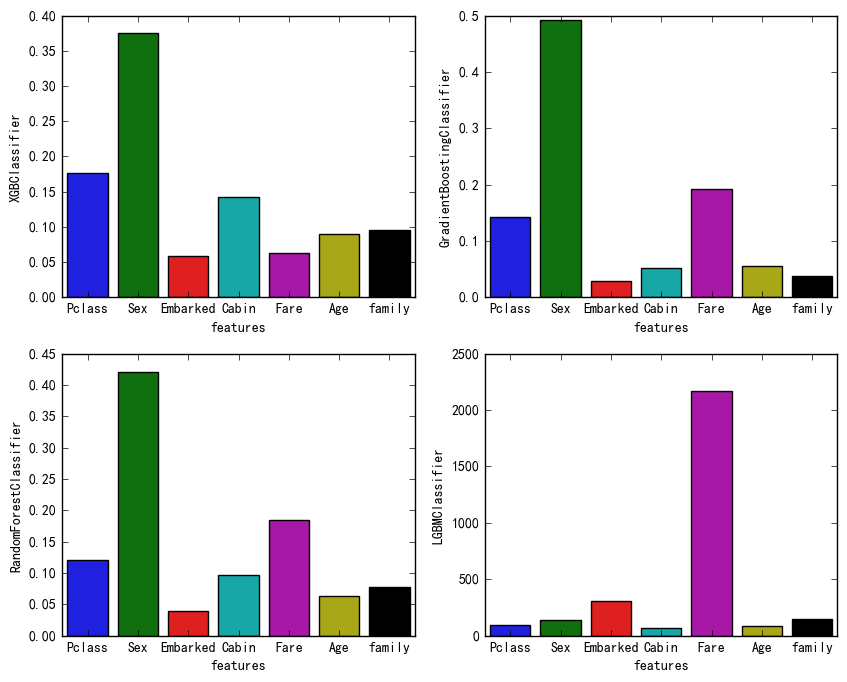

In [50]:
plt.figure(figsize=(10,8))
plt.subplot(2,2,1)
sns.barplot(x='features', y='XGBClassifier', data=feature_dataframe)
plt.subplot(2,2,2)
sns.barplot(x='features', y='GradientBoostingClassifier', data=feature_dataframe)
plt.subplot(2,2,3)
sns.barplot(x='features', y='RandomForestClassifier', data=feature_dataframe)
plt.subplot(2,2,4)
sns.barplot(x='features', y='LGBMClassifier', data=feature_dataframe)

In [79]:
predict_result=pd.DataFrame({"PassengerId":raw_test['PassengerId'],"Survived":clf_grids['XGBClassifier'][4].astype('int')})

In [81]:
predict_result.to_csv(r"C:\Users\corem\Documents\Python Scripts\titanic\predict_result.csv",index=False)